# MobileNetv2 trained on lager cytopix ds and with ds augmentation


## 2024-08-20



In [ ]:
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

In [ ]:
import tensorflow as tf
import keras

print(tf.__version__)
keras.backend.clear_session()

tf.random.set_seed(42)

Defining custom functions

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay


def get_confusion_matrix(y_test, y_pred, class_names):

    _, ax = plt.subplots(figsize=(8, 8))
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        ax=ax,
        xticks_rotation="vertical",
        colorbar=False,
        normalize="true",
        display_labels=class_names,
    )

    plt.rc("font", size=12)
    ax.set_title(f"Confusion Matrix")


def plot_history(history, metrics):
    history_df = pd.DataFrame.from_dict(history.history)
    sns.lineplot(data=history_df[metrics])
    plt.xlabel("epochs")
    plt.ylabel("metric")

Load in model weights

Imagestrean data train and test split

In [ ]:
path_in = "/home/t.afanasyeva/deep_learning_anaemias/resources/imagestream"

In [ ]:
from collections import Counter


def calculate_class_distribution(ds):
    class_counts = Counter()
    y_train = [y.numpy().item() for _, y in ds]

    for my_class in y_train:
        class_counts[my_class] += 1

    class_counts = {ds.class_names[key]: value for key, value in class_counts.items()}

    total = sum(class_counts.values())
    class_ratios = {k: v / total for k, v in class_counts.items()}
    return (class_counts, class_ratios)

In [ ]:
from keras.layers import (
    Rescaling,
    RandomFlip,
    RandomRotation,
    RandomTranslation,
    RandomContrast,
    RandomBrightness,
)

AUTOTUNE = tf.data.AUTOTUNE

rescale = tf.keras.Sequential([Rescaling(1.0 / 255)])
data_augmentation = tf.keras.Sequential(
    [
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.2),
        RandomTranslation(0.2, 0.2),
        RandomContrast(0.2),
        RandomBrightness(0.2),
    ]
)


def prepare(ds, batch_size, initial_dist=None, target_dist=None, augment=False):

    ds = ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)

    if augment:

        # Correct imbalance in class distribution
        ds = ds.rejection_resample(
            class_func=lambda x, y: y,
            initial_dist=initial_dist,
            target_dist=target_dist,
            seed=93,
        )

        # Flatten rejection resampling outputs ((class_func_results, x), y)
        ds = ds.map(lambda _, data: data)

        # Add augmentation to images
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE,
        )

    ds = ds.batch(batch_size, num_parallel_calls=AUTOTUNE)

    return ds.prefetch(buffer_size=AUTOTUNE)

In [8]:
IMG_SIZE = (96, 96)
BATCH_SIZE = 24

train_ds, test_ds = keras.utils.image_dataset_from_directory(
    path_in,
    labels="inferred",
    label_mode="int",
    class_names=["discocyte", "granular", "holly_leaf", "sickle", "echinocyte"],
    color_mode="rgb",
    batch_size=None,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=93,
    validation_split=0.2,
    subset="both",
    data_format="channels_last",
    verbose=True,
)


class_names = test_ds.class_names

_, prior_distribution = calculate_class_distribution(train_ds)
initial_dist = list(prior_distribution.values())
target_dist = [0.2, 0.2, 0.2, 0.2, 0.2]

steps_per_epoch = len(train_ds) // BATCH_SIZE
validation_steps = len(test_ds) // BATCH_SIZE

train_ds = prepare(
    train_ds,
    target_dist=target_dist,
    initial_dist=initial_dist,
    batch_size=BATCH_SIZE,
    augment=True,
)

test_ds = prepare(
    test_ds,
    batch_size=BATCH_SIZE,
)

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



2024-08-21 19:47:12.919491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

EPOCHS = 200

earlystopper = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)


def learning_rate_schedule(epoch, lr):
    if epoch < 5:
        return (lr * tf.math.exp(0.5)).numpy()
    if epoch < 15:
        return lr
    else:
        return (lr * tf.math.exp(-0.1)).numpy()


lr_scheduler = LearningRateScheduler(learning_rate_schedule)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    BatchNormalization,
    ReLU,
    GlobalAveragePooling2D,
)
from tensorflow.keras.regularizers import L2
from tensorflow.keras.applications import MobileNetV2


mobile_net = keras.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
)

model = Sequential()

model.add(mobile_net)
model.add(GlobalAveragePooling2D())
model.add(Dense(5, activation="softmax"))


optimizer = keras.optimizers.Adam(learning_rate=0.01)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [15]:
with tf.device("GPU:0"):
    history = model.fit(
        train_ds.repeat(),
        validation_data=test_ds.repeat(),
        callbacks=[earlystopper, lr_scheduler],
        epochs=EPOCHS,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        validation_freq=2,
        verbose=2,
    )

Epoch 1/200


Proportion of examples rejected by sampler is high: [0.844731212][0.301618397 0.14386712 0.412947178 0.0525553674 0.0890119225][0.0538259558 0.272748351 0 1 0.530703783]
Proportion of examples rejected by sampler is high: [0.844731212][0.301618397 0.14386712 0.412947178 0.0525553674 0.0890119225][0.0538259558 0.272748351 0 1 0.530703783]
Proportion of examples rejected by sampler is high: [0.844731212][0.301618397 0.14386712 0.412947178 0.0525553674 0.0890119225][0.0538259558 0.272748351 0 1 0.530703783]
Proportion of examples rejected by sampler is high: [0.844731212][0.301618397 0.14386712 0.412947178 0.0525553674 0.0890119225][0.0538259558 0.272748351 0 1 0.530703783]
Proportion of examples rejected by sampler is high: [0.844731212][0.301618397 0.14386712 0.412947178 0.0525553674 0.0890119225][0.0538259558 0.272748351 0 1 0.530703783]
Proportion of examples rejected by sampler is high: [0.844731212][0.301618397 0.14386712 0.412947178 0.0525553674 0.0890119225][0.0538259558 0.2727483

489/489 - 69s - 142ms/step - accuracy: 0.3020 - loss: 1.7468 - learning_rate: 0.0165
Epoch 2/200


/home/t.afanasyeva/miniforge3/envs/IMG/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


489/489 - 40s - 81ms/step - accuracy: 0.3209 - loss: 1.4867 - val_accuracy: 0.2941 - val_loss: 3.5256 - learning_rate: 0.0272
Epoch 3/200
489/489 - 36s - 74ms/step - accuracy: 0.3262 - loss: 1.4825 - learning_rate: 0.0448
Epoch 4/200
489/489 - 39s - 79ms/step - accuracy: 0.3131 - loss: 1.5068 - val_accuracy: 0.0955 - val_loss: 1.9517 - learning_rate: 0.0739
Epoch 5/200
489/489 - 24s - 49ms/step - accuracy: 0.3148 - loss: 1.4908 - learning_rate: 0.1218
Epoch 6/200


I0000 00:00:1724262680.131672  895117 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_25', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1724262697.663030  895116 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 8 bytes spill stores, 8 bytes spill loads



489/489 - 37s - 75ms/step - accuracy: 0.3098 - loss: 1.4841 - val_accuracy: 0.4038 - val_loss: 1.4790 - learning_rate: 0.1218
Epoch 7/200


I0000 00:00:1724262716.486892  895115 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_18', 16 bytes spill stores, 16 bytes spill loads



489/489 - 36s - 74ms/step - accuracy: 0.3121 - loss: 1.4900 - learning_rate: 0.1218
Epoch 8/200
489/489 - 12s - 25ms/step - accuracy: 0.3163 - loss: 1.4859 - val_accuracy: 0.2935 - val_loss: 1.5091 - learning_rate: 0.1218
Epoch 9/200


I0000 00:00:1724262761.967722  895115 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_19', 16 bytes spill stores, 16 bytes spill loads



489/489 - 23s - 47ms/step - accuracy: 0.3198 - loss: 1.4847 - learning_rate: 0.1218
Epoch 10/200
489/489 - 12s - 25ms/step - accuracy: 0.3203 - loss: 1.4816 - val_accuracy: 0.4027 - val_loss: 1.4623 - learning_rate: 0.1218
Epoch 11/200


I0000 00:00:1724262801.291085  895114 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_16', 16 bytes spill stores, 16 bytes spill loads



489/489 - 24s - 49ms/step - accuracy: 0.3151 - loss: 1.4842 - learning_rate: 0.1218
Epoch 12/200
489/489 - 25s - 52ms/step - accuracy: 0.3107 - loss: 1.4870 - val_accuracy: 0.1519 - val_loss: 1.5648 - learning_rate: 0.1218
Epoch 13/200
489/489 - 11s - 23ms/step - accuracy: 0.3110 - loss: 1.4863 - learning_rate: 0.1218
Epoch 14/200
489/489 - 12s - 25ms/step - accuracy: 0.3118 - loss: 1.4903 - val_accuracy: 0.2945 - val_loss: 1.5113 - learning_rate: 0.1218
Epoch 15/200
489/489 - 12s - 24ms/step - accuracy: 0.3132 - loss: 1.4836 - learning_rate: 0.1218
Epoch 16/200
489/489 - 12s - 25ms/step - accuracy: 0.3084 - loss: 1.4860 - val_accuracy: 0.4024 - val_loss: 1.4998 - learning_rate: 0.1102


In [16]:
history.history["val_loss"] = [
    val for val in history.history["val_loss"] for _ in range(2)
]
history.history["val_accuracy"] = [
    val for val in history.history["val_accuracy"] for _ in range(2)
]

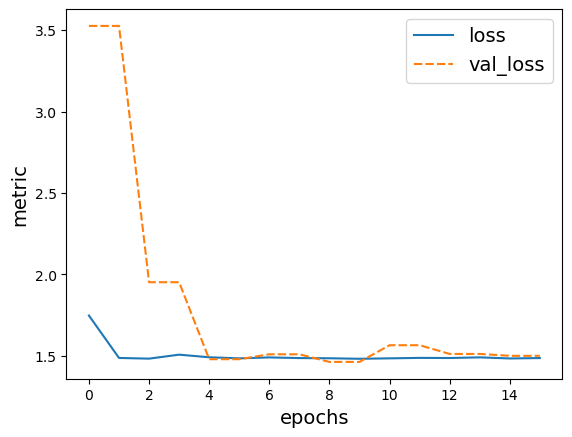

In [17]:
plot_history(history, ["loss", "val_loss"])

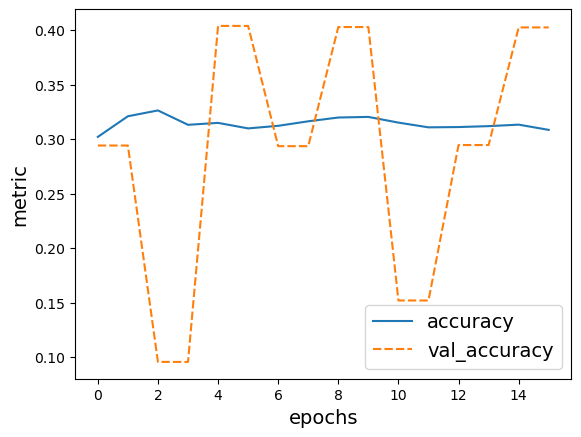

In [18]:
plot_history(history, ["accuracy", "val_accuracy"])

In [19]:
y_test = tf.concat([y for _, y in test_ds], axis=0)
y_train = tf.concat([y for _, y in train_ds], axis=0)
y_pred = model.predict(test_ds)
y_pred = y_pred.argmax(axis=1)

2024-08-21 19:54:40.156763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Proportion of examples rejected by sampler is high: [0.844731212][0.301618397 0.14386712 0.412947178 0.0525553674 0.0890119225][0.0538259558 0.272748351 0 1 0.530703783]
Proportion of examples rejected by sampler is high: [0.844731212][0.301618397 0.14386712 0.412947178 0.0525553674 0.0890119225][0.0538259558 0.272748351 0 1 0.530703783]
Proportion of examples rejected by sampler is high: [0.844731212][0.301618397 0.14386712 0.412947178 0.0525553674 0.0890119225][0.0538259558 0.272748351 0 1 0.530703783]
Proportion of examples rejected by sampler is high: [0.844731212][0.301618397 0.14386712 0.412947178 0.0525553674 0.0890119225][0.0538259558 0.272748351 0 1 0.530703783]
Proportion of examples rejected by sampler is high: [0.844731212][0.301618397 0.14386712 0.412947178 0.0525553674 0.0890119225][0.0538259558 0.272748351 0 1 0.53070378

123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step


In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   discocyte       0.40      1.00      0.57      1183
    granular       0.00      0.00      0.00       863
  holly_leaf       0.00      0.00      0.00       280
      sickle       0.00      0.00      0.00       162
  echinocyte       0.00      0.00      0.00       446

    accuracy                           0.40      2934
   macro avg       0.08      0.20      0.11      2934
weighted avg       0.16      0.40      0.23      2934



/home/t.afanasyeva/miniforge3/envs/IMG/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/t.afanasyeva/miniforge3/envs/IMG/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/t.afanasyeva/miniforge3/envs/IMG/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

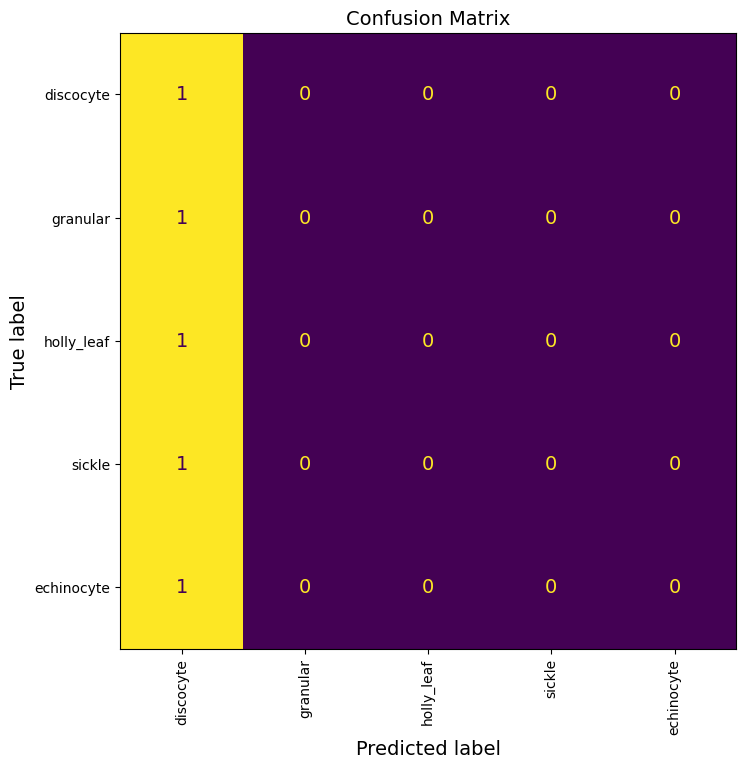

In [21]:
get_confusion_matrix(y_test, y_pred, class_names)

Turining off mobile_net layer for training

In [22]:
for layer in mobile_net.layers[:-100]:
    layer.trainable = False

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [23]:
path_in = "/home/t.afanasyeva/deep_learning_anaemias/resources/training"

In [24]:
cp_train_ds, cp_test_ds = keras.utils.image_dataset_from_directory(
    path_in,
    labels="inferred",
    label_mode="int",
    class_names=["discocyte", "holly_leaf", "granular", "sickle", "echinocyte"],
    color_mode="rgb",
    batch_size=None,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=93,
    validation_split=0.2,
    subset="both",
    data_format="channels_last",
    verbose=True,
)

Found 13571 files belonging to 5 classes.
Using 10857 files for training.
Using 2714 files for validation.


In [25]:
prior_counts, prior_distribution = calculate_class_distribution(cp_train_ds)
initial_dist = list(prior_distribution.values())

2024-08-21 19:54:50.157605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'discocyte': 0.806023763470572, 'holly_leaf': 0.05572441742654509, 'sickle': 0.03923735838629456, 'granular': 0.07515888366952196, 'echinocyte': 0.02385557704706641}


<Axes: >

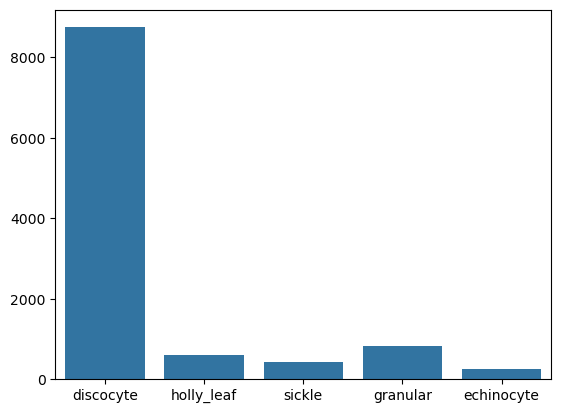

In [26]:
print(prior_distribution)
sns.barplot(prior_counts)

In [27]:
cp_train_ds = prepare(
    cp_train_ds,
    target_dist=target_dist,
    initial_dist=initial_dist,
    batch_size=BATCH_SIZE,
    augment=True,
)
cp_test_ds = prepare(
    cp_test_ds,
    batch_size=BATCH_SIZE,
)

In [28]:
for data, label in cp_train_ds.take(1):
    print(f"Train data shape: {data.shape}, label shape: {label.shape}")

Train data shape: (24, 96, 96, 3), label shape: (24,)


Proportion of examples rejected by sampler is high: [0.907583475][0.806023777 0.0557244159 0.0392373577 0.0751588866 0.0238555763][0 0.410656601 0.596024871 0.296583176 1]
Proportion of examples rejected by sampler is high: [0.907583475][0.806023777 0.0557244159 0.0392373577 0.0751588866 0.0238555763][0 0.410656601 0.596024871 0.296583176 1]
Proportion of examples rejected by sampler is high: [0.907583475][0.806023777 0.0557244159 0.0392373577 0.0751588866 0.0238555763][0 0.410656601 0.596024871 0.296583176 1]
Proportion of examples rejected by sampler is high: [0.907583475][0.806023777 0.0557244159 0.0392373577 0.0751588866 0.0238555763][0 0.410656601 0.596024871 0.296583176 1]
Proportion of examples rejected by sampler is high: [0.907583475][0.806023777 0.0557244159 0.0392373577 0.0751588866 0.0238555763][0 0.410656601 0.596024871 0.296583176 1]
Proportion of examples rejected by sampler is high: [0.907583475][0.806023777 0.0557244159 0.0392373577 0.0751588866 0.0238555763][0 0.41065

In [29]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   discocyte       0.40      1.00      0.57      1183
    granular       0.00      0.00      0.00       863
  holly_leaf       0.00      0.00      0.00       280
      sickle       0.00      0.00      0.00       162
  echinocyte       0.00      0.00      0.00       446

    accuracy                           0.40      2934
   macro avg       0.08      0.20      0.11      2934
weighted avg       0.16      0.40      0.23      2934



/home/t.afanasyeva/miniforge3/envs/IMG/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/t.afanasyeva/miniforge3/envs/IMG/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/t.afanasyeva/miniforge3/envs/IMG/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

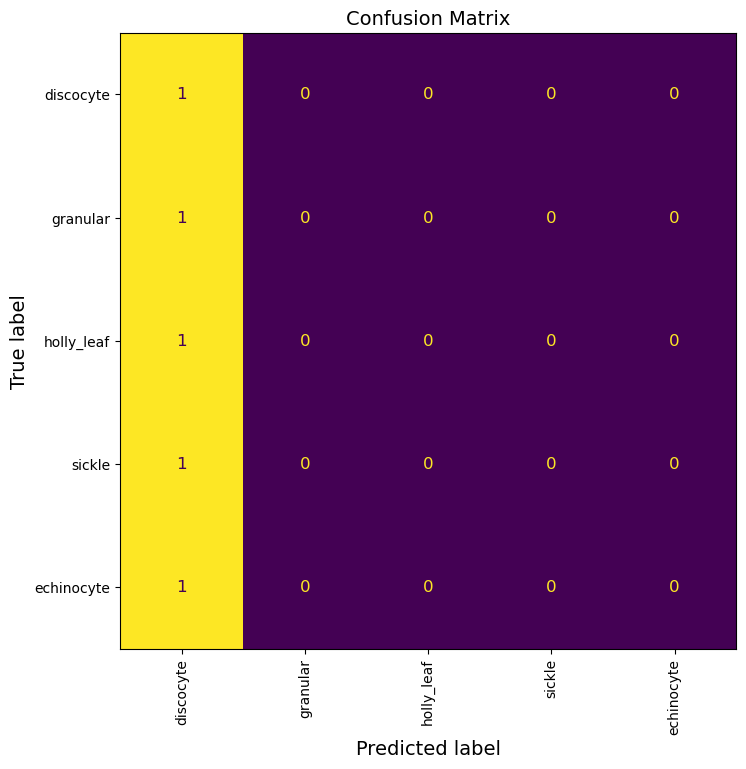

In [30]:
get_confusion_matrix(y_test, y_pred, class_names)